In [1]:
import ijson
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [3]:
def extract_json_data_into_dataframe(json_file_path: str, no_of_entries: int) -> pd.DataFrame:
    """
    extracts the json data from the json file and returns a pandas dataframe
    :param json_file_path: path to the json file
    :param no_of_entries: number of entries to be extracted from the json file
    :return: pandas dataframe containing the extracted data
    """
    df = pd.DataFrame()

    f = open(json_file_path, 'r')
    for i, json_event in enumerate(ijson.items(f, 'item')):
        single_df = pd.json_normalize(json_event)
        df = pd.concat([df, single_df], ignore_index=True)
        if i == no_of_entries:
            break
    f.close()

    return df

df = extract_json_data_into_dataframe('stuttgart_events.json', 1000)
print(df)

                                                                                                                             id  \
0                                              prinz.de/stuttgart/events/515144-gedenktag-fuer-die-verstorbenen-drogenabhaeng-1   
1                                                                      prinz.de/stuttgart/events/172968-get-shorties-lesebuehne   
2                                                      prinz.de/stuttgart/events/200783-stuttgarter-saloniker-neujahrskonzert-1   
3                                                                                   prinz.de/stuttgart/events/424139-beefcake-2   
4                                                                     prinz.de/stuttgart/events/203179-3durch3reihe-sprachkunst   
5                                                                          prinz.de/stuttgart/events/185016-grand-hotel-abgrund   
6                                                                                  

# Data Preprocessing

## Remove all events that take place at locations not in Stuttgart

In [4]:
def remove_events_not_in_stuttgart(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove all events not in Stuttgart by looking at the evntData.location.location.city column
    :param df: dataframe containing the events
    :return: dataframe containing only events in Stuttgart (might be the same as inpt df)
    """
    df = df[df['eventData.location.location.address.city'] == 'Stuttgart']
    return df

df = remove_events_not_in_stuttgart(df)

In [5]:
print(df.shape)

(1001, 60)


### Check for NA values

In [6]:
# check for NA values
print(df.isna().sum())

id                                                            0
hostname                                                      0
eventData.name                                                0
eventData.description                                        23
eventData.sourceId                                            0
eventData.url                                                 0
eventData.startDate                                           0
eventData.endDate                                          1001
eventData.doorTime                                         1001
eventData.cancelled                                           0
eventData.location.sourceId                                   0
eventData.location.url                                        0
eventData.location.name                                       0
eventData.location.description                             1001
eventData.location.location.name                              0
eventData.location.location.address.coun

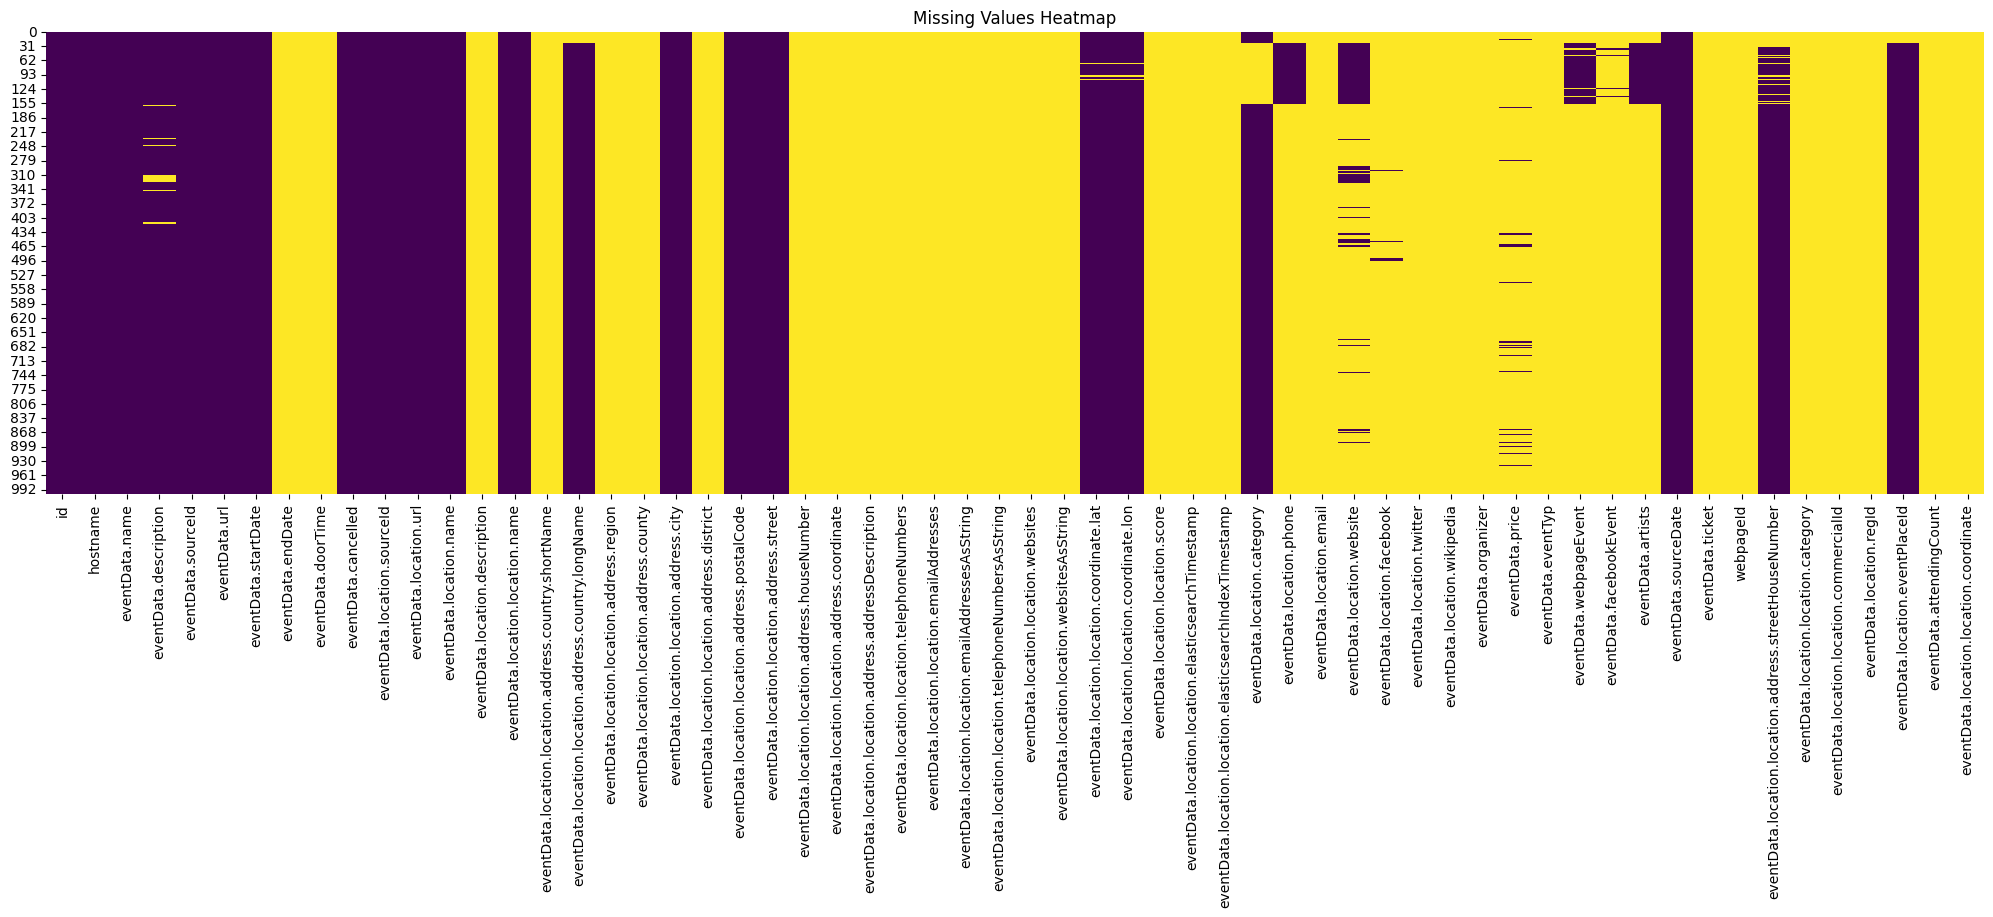

In [7]:
# Create a heatmap of missing values
plt.figure(figsize=(25, 6))  # Adjust the figure size as needed
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

Interpretation: The yellow area shows the NA values. There is a lot of missing data 😨

In [8]:
# delete columns with more than 10% missing values
df = df[df.columns[df.isnull().mean() < 0.25]]
print(df.shape)

(1001, 22)


We just deleted a ton of columns because they all contain a lot of missing values and are probably not helpful for further analysis.

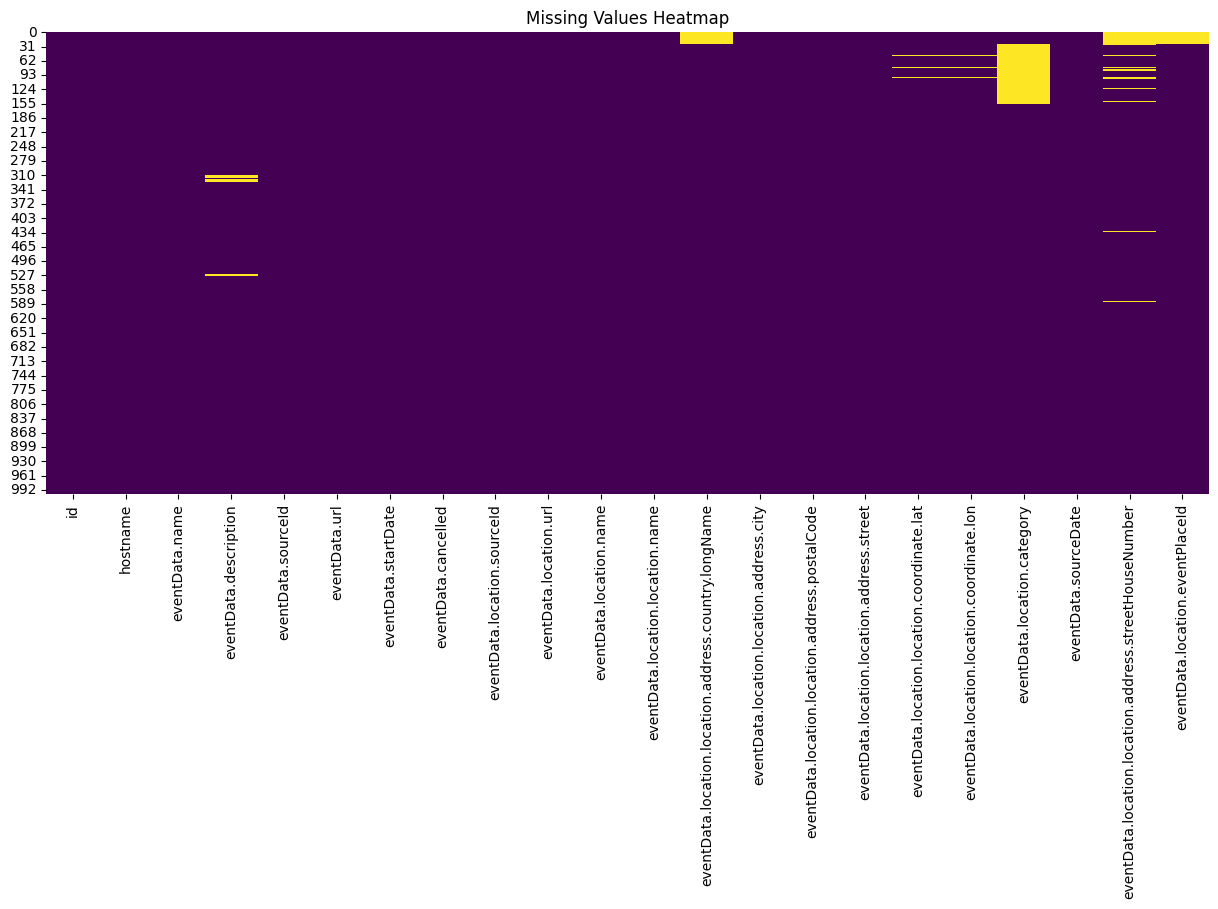

In [9]:
# again plot missing values after cleaning
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

Only latitude and longitude still contain missing values which is quite good. The missing values also always come together.

In [10]:
# check datatypes
print(df.dtypes)

id                                                       object
hostname                                                 object
eventData.name                                           object
eventData.description                                    object
eventData.sourceId                                       object
eventData.url                                            object
eventData.startDate                                      object
eventData.cancelled                                        bool
eventData.location.sourceId                              object
eventData.location.url                                   object
eventData.location.name                                  object
eventData.location.location.name                         object
eventData.location.location.address.country.longName     object
eventData.location.location.address.city                 object
eventData.location.location.address.postalCode           object
eventData.location.location.address.stre

In [11]:
print(df.loc[50,])

id                                                                                                                                                                                                                                                                                                                                     www.last.fm/event/3129361+LAING+Live+2012
hostname                                                                                                                                                                                                                                                                                                                                                             www.last.fm
eventData.name                                                                                                                                                                                                                                                        

In [12]:
# delete all events which were cancelled
df = df[df['eventData.cancelled'] == False]

# Feature Engineering

In [13]:
# Convert the date columns to datetime
df['eventData.startDate'] = pd.to_datetime(df['eventData.startDate'], format='%Y-%m-%dT%H:%M:%S')
try:
    df['eventData.sourceDate'] = pd.to_datetime(df['eventData.sourceDate'], format='mixed', errors='coerce')
except:
    print('eventData.sourceDate could not be converted to datetime')


In [14]:
# add a column for the day of the week by using the startDate column
df['dayofweek'] = df['eventData.startDate'].dt.dayofweek


In [15]:
print(df['dayofweek'].value_counts())

dayofweek
5    273
4    211
3    128
6    117
2    108
1     85
0     70
Name: count, dtype: int64


Apparently, 0 means Monday, 1 means Tuesday, 2 means Wednesday and so on...
We only want to have information about events on Wednesdays, so number 2.

In [16]:
# only consider Wednesdays and drop all other days
df = df[df['dayofweek'] == 2]
df.reset_index(drop=True, inplace=True)
df.shape

(108, 23)

In [17]:
# Create a year column
df['year'] = df['eventData.startDate'].dt.year

In [18]:
# Create a month column
df['month'] = df['eventData.startDate'].dt.month

In [19]:
# Create feature season

# create a function to determine the season
def get_season(date: pd.Timestamp) -> str:
    """
    returns the season of a given date
    :param date: date for which the season should be determined
    :return: season of the given date
    """
    # spring
    if date.month >= 3 and date.month <= 5:
        return 'spring'
    # summer
    elif date.month >= 6 and date.month <= 8:
        return 'summer'
    # autumn
    elif date.month >= 9 and date.month <= 11:
        return 'autumn'
    # winter
    else:
        return 'winter'

# apply the function to the startDate column
df['season'] = df['eventData.startDate'].apply(get_season)

In [20]:
df['eventData.location.location.address.postalCode'].value_counts()

eventData.location.location.address.postalCode
70173    27
70174    18
70178    15
70372     9
70469     6
70191     6
          6
70182     5
70567     4
70193     2
70180     2
70184     2
70188     2
70376     1
70176     1
70190     1
70329     1
Name: count, dtype: int64

In [21]:
# instead of having to choose location based on postcal code, it would be way nicer to choose location based on district
# therefore we need to add a column containing the district of the event
# we can get the district by using a mapping from postcal code to district
# https://home.meinestadt.de/stuttgart/postleitzahlen

zip_code_to_district = {
    "70173": "Europaviertel",
    "70174": "Relenberg",
    "70178": "Karlshöhe",
    "70191": "Am Rosensteinpark",
    "70193": "Kräherwald",
    "70195": "Botnang-West",
    "70197": "Vogelsang",
    "70199": "Südheim",
    "70372": "Bad Cannstatt",
    "70567": "Sternhäule",
    "70569": "Pfaffenwald",
    "70437": "Freiberg",
    "70176": "Rosenberg",
    "70188": "Uhlandshöhe",
    "70374": "Im Geiger",
    "70439": "Zuffenhausen-Elbelen",
    "70190": "Stöckach",
    "70180": "Weinsteige",
    "70182": "Heusteigviertel",
    "70376": "Neckarvorstadt",
    "70378": "Mönchfeld",
    "70597": "Waldau",
    "70565": "Möhringen-Süd",
    "70469": "Feuerbach-Ost",
    "70199": "Südheim"
}


def get_district_from_postcal_code(postcalCode: int):
    """
    returns the district of a given postal code
    :param postcalCode: postal code for which the district should be determined
    :return: district of the given postal code
    """
    try:
        district = zip_code_to_district[str(postcalCode)]
    except KeyError:
        district = "Other"
    return district
    
# apply the function to the postal code column
df['district'] = df['eventData.location.location.address.postalCode'].apply(get_district_from_postcal_code)
    

In [22]:
df.loc[100,]

id                                                                                   prinz.de/stuttgart/events/403570-endless
hostname                                                                                                             prinz.de
eventData.name                                                                                                        endless
eventData.description                                    Das Projekt „endless“ von Saxophonist und Elektromusiker Steffen Dix
eventData.sourceId                                                                                                     403570
eventData.url                                                                 http://prinz.de/stuttgart/events/403570-endless
eventData.startDate                                                                                       2014-04-30 08:30:00
eventData.cancelled                                                                                                   

In [23]:
df['eventData.location.category'].value_counts()

eventData.location.category
kultur/buehne                        12
konzert/pop                          10
stadtleben/special-events             7
party/popcharts                       7
kultur/lesung                         6
konzert/jazzchanson                   6
party/black                           5
stadtleben/diskussion-vortrag         5
familie-kinder                        4
kultur/film-kino                      4
kultur/klassik                        3
konzert                               3
kultur/kunst                          3
kultur/ausstellung                    3
kultur/webtvradio                     2
party/electro                         2
konzert/hip-hop                       2
konzert/metal                         2
party/hip-hop                         1
konzert/punk                          1
konzert/country-folk-konzerte         1
konzert/klassik                       1
konzert/singersongwriter-konzerte     1
stadtleben/freizeit                   1
konzert/elec

There are basically two types of categories:
- super-category: determines the main function of the event
    - konzert
    - kultur
    - stadtleben
    - party
    - familie
- sub-category: For each super-category there are multiple sub-categories --> Might be cool to also have them on display when showing the event.

In [ ]:
# create features supercategory and subcategory
# split entry in eventData.location.category by / 
def extract_categories(df: pd.DataFrame):
    """
    extracts the supercategory and subcategory from the eventData.location.category column
    :param df: dataframe containing the events
    :return: dataframe containing the events with two new columns supercategory and subcategory
    """
    df['supercategory'] = df['eventData.location.category'].str.split('/').str[0]
    df['subcategory'] = df['eventData.location.category'].str.split('/').str[1]
    return df

df = extract_categories(df)


# Save dataframe to csv

In [24]:
# save output df to csv
df.to_csv('1000Events.csv', index=False)